# CycleGAN for Generating Monet Painting from Photos

University of Colorado Boulder

DTSA 5511 W5

## 1. Introduction and Problem Description

This project aims to solve the Kaggle "Monet Painting Dataset" competition, where the goal is to generate Monet-style paintings using deep learning techniques. The challenge is to build a generative adversarial network (GAN) that generates 7,000-10,000 images in the style of Monet paintings. Evaluation is based on MiFID (Memorization-informed Fréchet Inception Distance), which measures the quality and originality of the generated images. Lower MiFID scores indicate better quality.

### Dataset Overview
The dataset contains 300 Monet paintings sized 256x256 and 7,028 photos sized 256x256. I will use TFRecords format as recommended by the competition organizers.

## 2. Library Imports and Environment Setup

In [1]:
# Would you like to tune hyperparameters?
fine_tuning = True

In [2]:
# need to set up tmp directory because of kaggle kernel limit of 500 files
TMP_DIR = '../tmp'
IMAGES_TMP_DIR = f'{TMP_DIR}/images'

In [3]:
# NOTE: use GroupNormalization(groups=-1) instead of InstanceNormalization 
# from tensorflow_addons (deprecated) as suggested in tutorial notebook
# USE: result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
from tensorflow.keras import layers 

import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt

import matplotlib.pyplot as plt

import numpy as np
import os
import time
import gc
import io
import shutil

import zipfile
import PIL
from IPython.display import display, clear_output

2025-04-20 07:08:29.932465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745132910.120635      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745132910.179066      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def setup_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        device = 'TPU'
    except:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
            device = f'{len(gpus)} GPU(s)'
        else:
            strategy = tf.distribute.get_strategy()
            device = 'CPU'
    print(f'Using {device} with {strategy.num_replicas_in_sync} replicas')
    return strategy

strategy = setup_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE

Using 1 GPU(s) with 1 replicas



## 3. Data Loading and Exploration

### 3.1 Load TFRecord Files

In [5]:
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('Monet TFRecord Files:', len(MONET_FILENAMES))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
def decode_image(image):
    """Convert compressed image to float tensor with values in [-1, 1]"""
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    """Extract image from TFRecord"""
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, batch_size=1):
    """Load and prepare a TFRecord dataset"""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [7]:
IMAGE_SIZE = [256, 256]

BATCH_SIZE = 1
monet_ds = load_dataset(MONET_FILENAMES, BATCH_SIZE)
photo_ds = load_dataset(PHOTO_FILENAMES, BATCH_SIZE)

I0000 00:00:1745132924.572255      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### 3.2 EDA

In [8]:
example_monet  = next(iter(monet_ds))
example_photo  = next(iter(photo_ds))

In [9]:
def visualize_comparison(monet, photo):

        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('Monet Painting 1')
        plt.imshow(example_monet[0] * 0.5 + 0.5)
        
        plt.subplot(1, 2, 2)
        plt.title('Photo 1')
        plt.imshow(example_photo[0] * 0.5 + 0.5)
                
        plt.show()

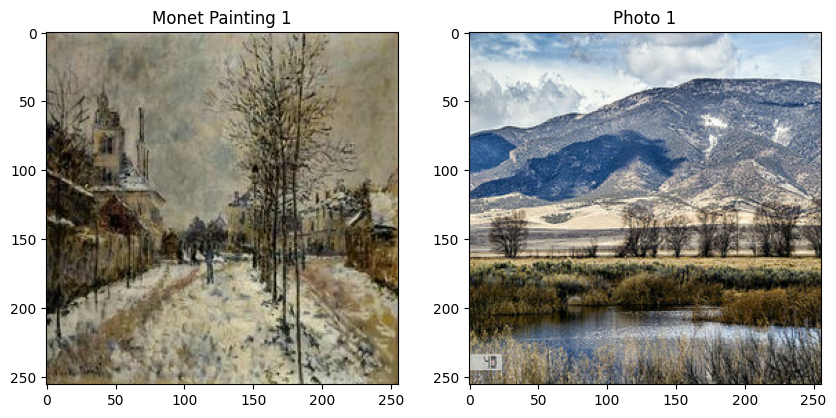

In [10]:
visualize_comparison(example_monet, example_photo)

In [11]:
def visualize_samples(dataset, title, n):
    
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.title(f'{title} sample {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

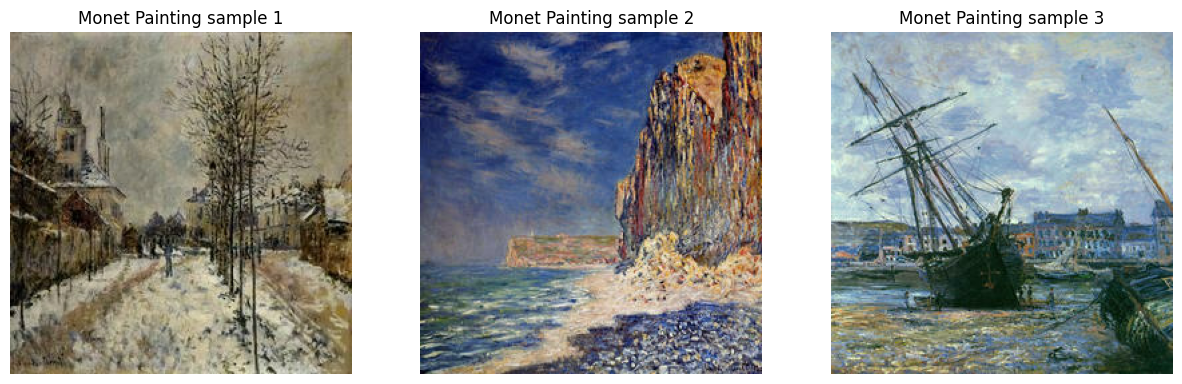

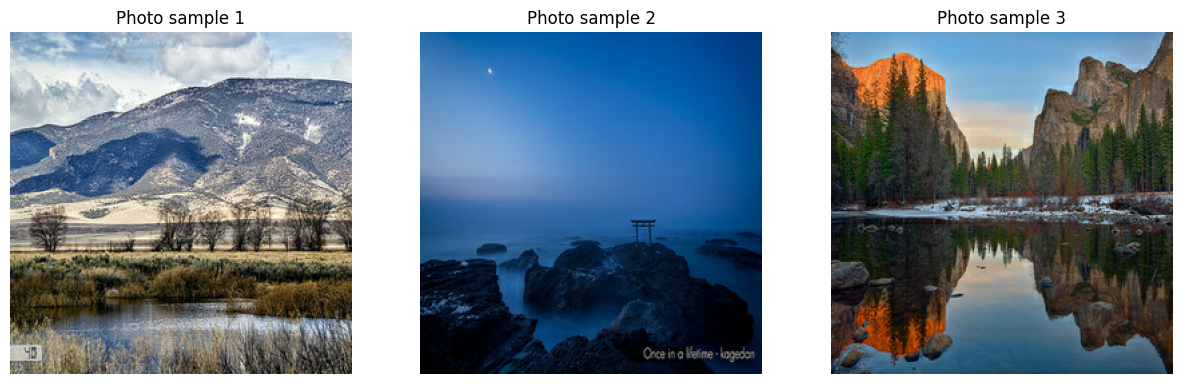

In [12]:
visualize_samples(dataset=monet_ds, title='Monet Painting', n=3)
visualize_samples(dataset=photo_ds, title='Photo', n=3)

In [13]:
def visualize_RGB_distribution(image, title):
    # rescale from [-1,1] to [0,255]
    img = ((image[0] * 0.5 + 0.5) * 255).numpy().astype(np.uint8)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title(title)
    plt.imshow(img)
    
    # histogram for each channel
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        plt.subplot(1, 4, i+2)
        plt.title(f'{color.capitalize()} Channel')
        plt.hist(img[:,:,i].flatten(), bins=50, color=color, alpha=0.7)
        plt.xlim([0, 255])
    plt.tight_layout()
    plt.show()

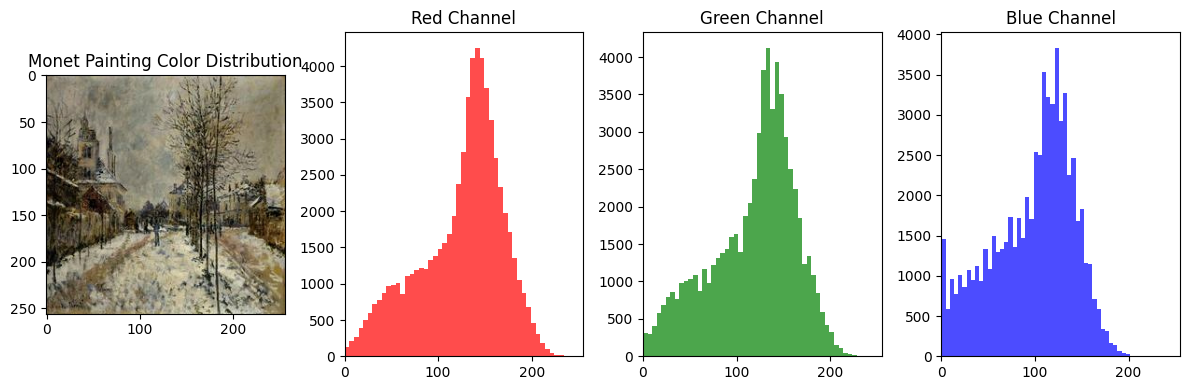

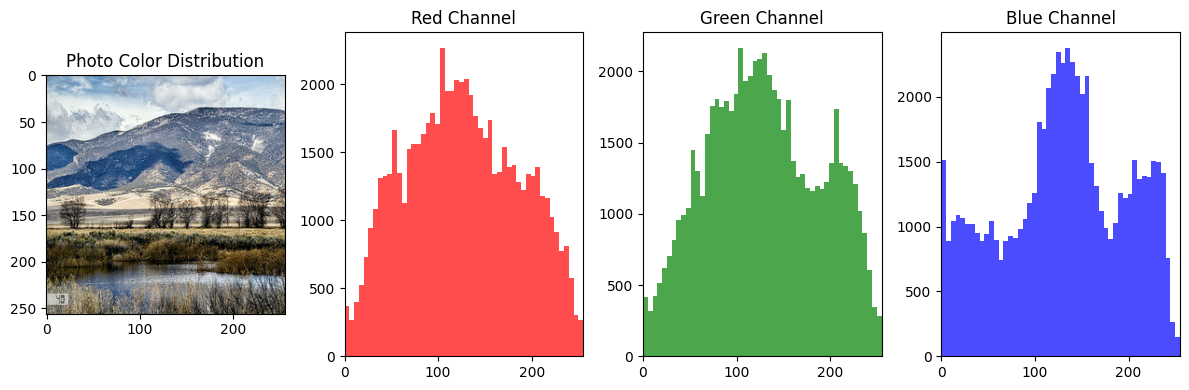

In [14]:
visualize_RGB_distribution(example_monet, 'Monet Painting Color Distribution')
visualize_RGB_distribution(example_photo, 'Photo Color Distribution')

### 3.3 EDA Findings and Insights
Looking at the dataset, I see several key differences between Monet paintings and regular photographs.

The color palette used in the paintings is comprised of softer tones, especially blues and greens. The color histograms show that there is much grater variation in each color channel in the photographs compared to the paintings. I imagine this makes sense because the photographs can capture more variation in color than a painter could likley mix on his paint palette. Also, the natural colors of the earth aren't all exactly sold in aluminum squeeze tubes. Monet's style is characterized by visible brush strokes and textured surfaces that are not present in high-fidelity photos. Both the paintings and the photos feature landscapes, water scenes, and natural settings. As we would expect, the photographs contain sharper details, while the paintings have a blended and blurred appearance.

## 4. Model Architecture

I implement a CycleGAN architecture, which is effective for unpaired image-to-image translation. This model consists of two generators. There is a Monet generator that transforms photos into paintings, and there is a photo generator that turns paintings into photos. Two discriminators are also part of the architecture. The Monet discriminator differentiates real monet paintings from generated ones while the photo discriminators has a similar function for photos.

### 4.1 Generator Architecture

In [15]:
OUTPUT_CHANNELS = 3  # RGB images

In [16]:
def downsample(filters, size, apply_instancenorm=True):
    """Downsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    """U-Net based generator with skip connections"""
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling path
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling path
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### 4.2 Discriminator Architecture

In [17]:
def Discriminator():
    """PatchGAN discriminator that classifies patches of an image as real or fake"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Downsampling layers
    down1 = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Additional layers
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    # Output layer - no activation to use with BCE loss
    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

### 4.3 Initialize Models

In [18]:
# Initialize models once
with strategy.scope():
    monet_generator = Generator()  # transforms photos to Monet-style paintings
    photo_generator = Generator()  # transforms Monet paintings to photo-like images
    monet_discriminator = Discriminator()  # discriminates real vs fake Monet paintings
    photo_discriminator = Discriminator()  # discriminates real vs fake photos

I0000 00:00:1745132930.383851      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


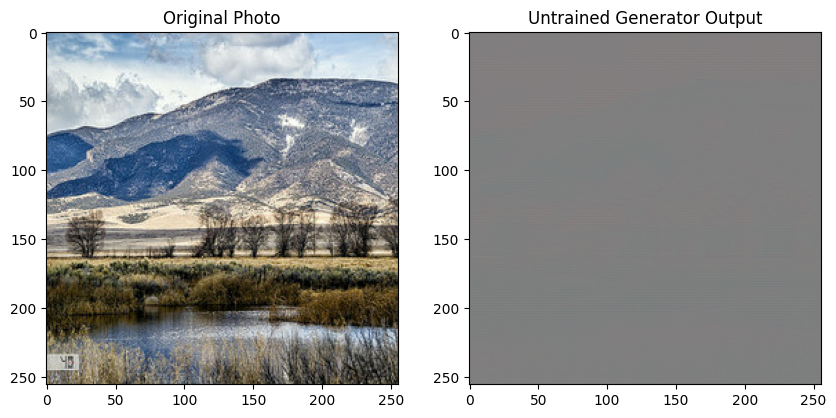

In [19]:
# test the untrained generator
to_monet = monet_generator(example_photo)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Untrained Generator Output")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

## 5. Loss Functions, Tuning, and Model Training

### 5.1 Define Loss Functions

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        """Discriminator loss - tries to correctly classify real vs generated images"""
        real_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
            
        generated_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
            
        total_disc_loss = real_loss + generated_loss
        
        return total_disc_loss * 0.5  # Average the losses

    def generator_loss(generated):
        """Generator loss - tries to fool discriminator to classify generated as real"""
        return tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        """Cycle consistency loss - ensures we can reconstruct original image"""
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss

    def identity_loss(real_image, same_image, LAMBDA):
        """Identity loss - encourages generators to preserve content when input is of target domain"""
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

### 5.2 CycleGAN Model

In [21]:
class CycleGan(keras.Model):
    """CycleGAN model that combines generators and discriminators with cycle consistency"""
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        """Execute one training step"""
        real_monet, real_photo = batch_data
        
        print(f"train_step received shapes: {real_monet.shape}, {real_photo.shape}")
    
        # Ensure 4D tensors - reshape if needed
        if len(real_monet.shape) > 4:
            real_monet = tf.reshape(real_monet, [-1, 256, 256, 3])
        if len(real_photo.shape) > 4:
            real_photo = tf.reshape(real_photo, [-1, 256, 256, 3])
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo to Monet to Photo (forward cycle)
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            # Monet to Photo to Monet (backward cycle)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # Identity mapping
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # Discriminator outputs
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Cycle consistency losses
            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )
            
            # Identity losses
            total_monet_gen_loss = (
                monet_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            )
            
            total_photo_gen_loss = (
                photo_gen_loss + 
                total_cycle_loss + 
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )
            
            # Discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate gradients
        monet_generator_gradients = tape.gradient(
            total_monet_gen_loss, self.m_gen.trainable_variables
        )
        photo_generator_gradients = tape.gradient(
            total_photo_gen_loss, self.p_gen.trainable_variables
        )
        
        monet_discriminator_gradients = tape.gradient(
            monet_disc_loss, self.m_disc.trainable_variables
        )
        photo_discriminator_gradients = tape.gradient(
            photo_disc_loss, self.p_disc.trainable_variables
        )
        
        # Apply gradients
        self.m_gen_optimizer.apply_gradients(
            zip(monet_generator_gradients, self.m_gen.trainable_variables)
        )
        self.p_gen_optimizer.apply_gradients(
            zip(photo_generator_gradients, self.p_gen.trainable_variables)
        )
        
        self.m_disc_optimizer.apply_gradients(
            zip(monet_discriminator_gradients, self.m_disc.trainable_variables)
        )
        self.p_disc_optimizer.apply_gradients(
            zip(photo_discriminator_gradients, self.p_disc.trainable_variables)
        )
        
        # Return metrics
        return {
            "monet_gen_loss": tf.reduce_mean(total_monet_gen_loss),
            "photo_gen_loss": tf.reduce_mean(total_photo_gen_loss),
            "monet_disc_loss": tf.reduce_mean(monet_disc_loss),
            "photo_disc_loss": tf.reduce_mean(photo_disc_loss)
        }

### 5.3 Hyperparameter Tuning and Model Compilation

In [22]:
def create_tuning_dataset(monet_ds, photo_ds, num_samples, batch_size=1):
    # Ensure both datasets are unbatched individual samples
    if hasattr(monet_ds, '_batch_size') and monet_ds._batch_size is not None:
        monet_ds = monet_ds.unbatch()
    if hasattr(photo_ds, '_batch_size') and photo_ds._batch_size is not None:
        photo_ds = photo_ds.unbatch()
    
    # Take samples from each dataset
    monet_subset = monet_ds.take(num_samples)
    photo_subset = photo_ds.take(num_samples)
    
    # Create a dataset of pairs (this is the key)
    tuning_dataset = tf.data.Dataset.zip((monet_subset, photo_subset))
    tuning_dataset = tuning_dataset.batch(batch_size)
    
    return tuning_dataset

# Utility function to configure optimizers
def configure_optimizers(learning_rate, beta1):
    """Create optimizers with learning rate schedule."""
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate,
        decay_steps=500,
        decay_rate=0.8,
        staircase=True
    )
    return [
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # monet_generator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # photo_generator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # monet_discriminator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1)   # photo_discriminator_optimizer
    ]

def build_tunable_cyclegan(hp):
    """Build CycleGAN with tunable hyperparameters using existing models."""
    lr = hp.Choice('learning_rate', values=[1e-4, 3e-4])
    beta1 = hp.Choice('beta1', values=[0.5, 0.7])
    lambda_cycle = hp.Choice('lambda_cycle', values=[5, 10])
    
    with strategy.scope():

        initial_weights = [
            monet_generator.get_weights(),
            photo_generator.get_weights(),
            monet_discriminator.get_weights(),
            photo_discriminator.get_weights()
        ]
        optimizers = configure_optimizers(lr, beta1)
        model = CycleGan(
            monet_generator,
            photo_generator,
            monet_discriminator,
            photo_discriminator,
            lambda_cycle=lambda_cycle
        )
        model.compile(
            m_gen_optimizer=optimizers[0],
            p_gen_optimizer=optimizers[1],
            m_disc_optimizer=optimizers[2],
            p_disc_optimizer=optimizers[3],
            gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss,
            identity_loss_fn=identity_loss
        )

        # Restore initial weights to ensure consistent starting point
        monet_generator.set_weights(initial_weights[0])
        photo_generator.set_weights(initial_weights[1])
        monet_discriminator.set_weights(initial_weights[2])
        photo_discriminator.set_weights(initial_weights[3])
    
    return model

In [23]:
if fine_tuning:

    if os.path.exists('./hyperparameter_tuning'):
        shutil.rmtree('./hyperparameter_tuning')

    tf.keras.backend.clear_session()
    gc.collect()
    
    TUNING_BATCH_SIZE = 1
    TUNING_SAMPLES = 50
    tuning_dataset = create_tuning_dataset(monet_ds, photo_ds, num_samples=TUNING_SAMPLES)
    tuning_dataset

In [24]:
tuner = kt.GridSearch(
    build_tunable_cyclegan,
    objective=kt.Objective('monet_gen_loss', direction="min"),
    max_trials=9,
    directory=f'{TMP_DIR}/hyperparameter_tuning',
    project_name='cyclegan_grid_tuning'
)

In [25]:
if fine_tuning:
    
    tuner.search(
        tuning_dataset,
        epochs=5,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
        verbose=1
    )
    
    best_hps = tuner.get_best_hyperparameters(1)[0]
    learning_rate = best_hps.get('learning_rate')
    beta1 = best_hps.get('beta1')
    lambda_cycle = best_hps.get('lambda_cycle')
    print(f"Best hyperparameters: Learning rate={learning_rate}, Beta1={beta1}, Lambda cycle={lambda_cycle}")

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print(f"Best hyperparameters found:")
    print(f"Learning rate: {best_hps.get('learning_rate')}")
    print(f"Beta1: {best_hps.get('beta1')}")
    print(f"Lambda cycle: {best_hps.get('lambda_cycle')}")

else:
    # default to last run's best hyper parameters (no need to set fine_tuning=True) 
    learning_rate, beta1, lambda_cycle = 1e-4, 0.7, 5

    # Use last run's best as default
    print(f"Defaulting to Last Run's Best:")
    print(f"Learning rate: {learning_rate}")
    print(f"Beta1: {beta1}")
    print(f"Lambda cycle: {lambda_cycle}")
    

Trial 8 Complete [00h 02m 42s]
monet_gen_loss: 2.770172119140625

Best monet_gen_loss So Far: 1.7676912546157837
Total elapsed time: 00h 20m 45s
Best hyperparameters: Learning rate=0.0003, Beta1=0.5, Lambda cycle=5
Best hyperparameters found:
Learning rate: 0.0003
Beta1: 0.5
Lambda cycle: 5


In [26]:
# # Apply the best hyperparameters to the final model
# learning_rate = best_hps.get('learning_rate')
# beta1 = best_hps.get('beta1')
# lambda_cycle = best_hps.get('lambda_cycle')

In [27]:
def plot_hyperparam_importance_from_oracle(tuner):
    # Access trials from the oracle
    trials = tuner.oracle.trials
    
    # Organize data for visualization
    param_data = {}
    
    # Extract hyperparameter values and corresponding scores
    for trial_id, trial in trials.items():
        score = trial.score  # This contains the objective metric value
        
        if score is not None:  # Ensure the trial completed and has a score
            for param_name, param_value in trial.hyperparameters.values.items():
                if param_name not in param_data:
                    param_data[param_name] = {'values': [], 'scores': []}
                
                param_data[param_name]['values'].append(param_value)
                param_data[param_name]['scores'].append(score)
    
    # Create visualizations
    num_params = len(param_data)
    plt.figure(figsize=(12, 4 * num_params))
    
    for i, (param_name, data) in enumerate(param_data.items()):
        plt.subplot(num_params, 1, i+1)
        
        # Convert values to strings for categorical plotting
        values = data['values']
        scores = data['scores']
        
        # Create boxplot for categorical parameters or scatterplot for numerical
        if len(set(values)) <= 5:  # Likely categorical or few distinct values
            # Group scores by parameter value
            value_groups = {}
            for val, score in zip(values, scores):
                if val not in value_groups:
                    value_groups[val] = []
                value_groups[val].append(score)
            
            # Prepare data for boxplot
            box_data = [scores for val, scores in sorted(value_groups.items())]
            labels = [str(val) for val in sorted(value_groups.keys())]
            
            plt.boxplot(box_data, labels=labels)
            plt.title(f'Impact of {param_name} on model performance')
        else:  # Numerical with many values
            plt.scatter(values, scores)
            plt.title(f'Impact of {param_name} on model performance')
        
        plt.xlabel(param_name)
        plt.ylabel('Score (monet_gen_loss)')
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

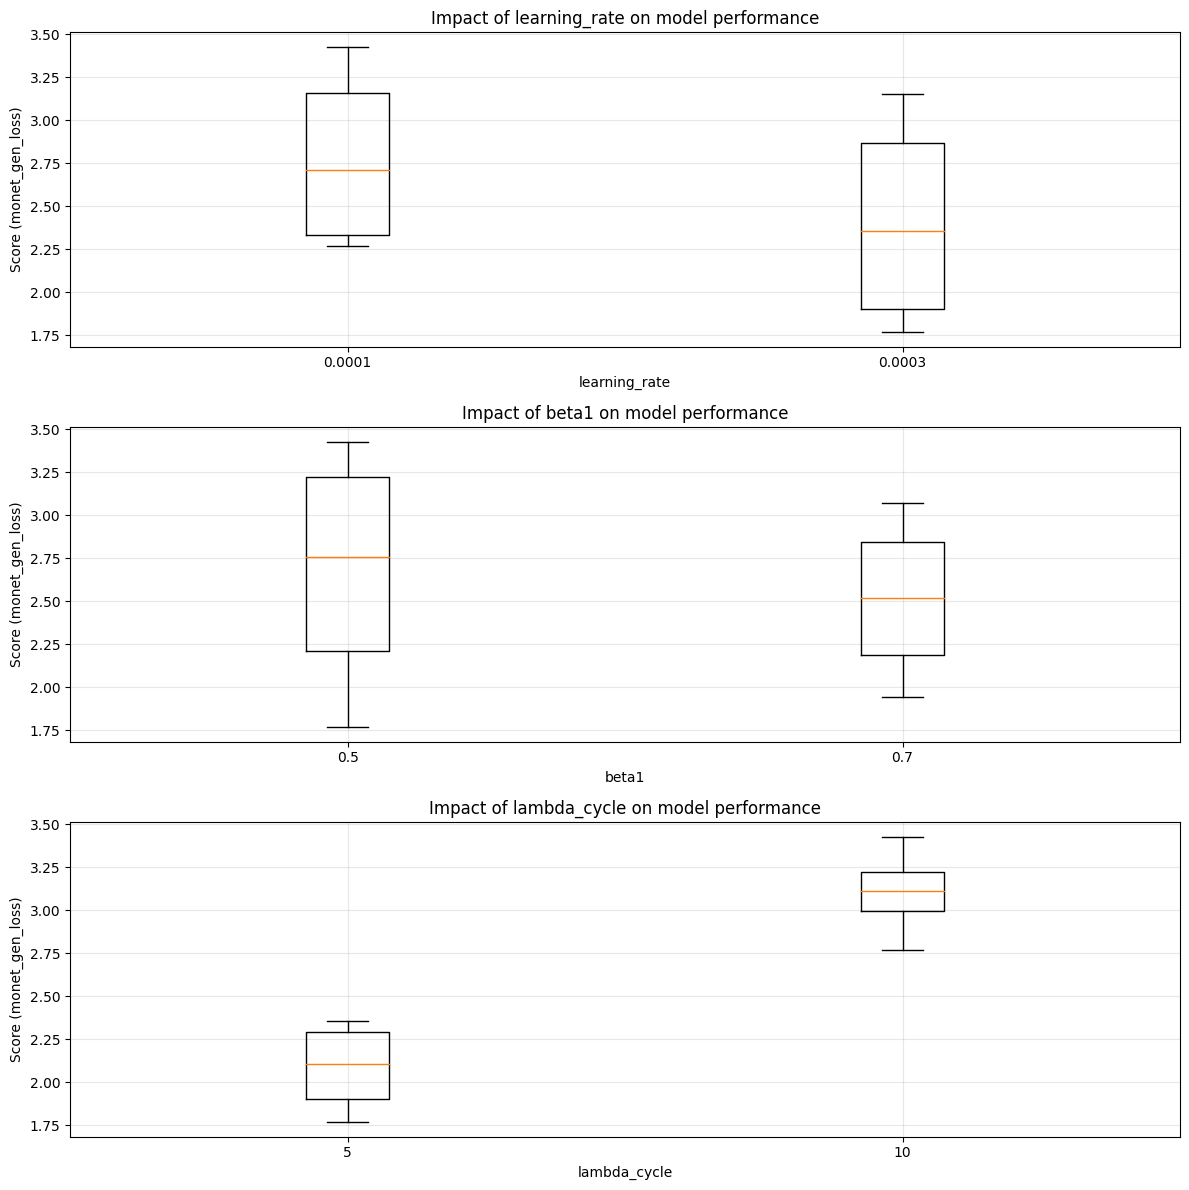

In [28]:
if fine_tuning:
    plot_hyperparam_importance_from_oracle(tuner)

In [29]:
# Compile final CycleGAN model with best hyperparameters
with strategy.scope():
    optimizers = configure_optimizers(learning_rate, beta1)
    cycle_gan_model = CycleGan(
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=lambda_cycle
    )
    cycle_gan_model.compile(
        m_gen_optimizer=optimizers[0],
        p_gen_optimizer=optimizers[1],
        m_disc_optimizer=optimizers[2],
        p_disc_optimizer=optimizers[3],
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

### 5.4 Epoch Visualization Functions

In [30]:
# Consolidated visualization functions for training progress
def generate_images(model, test_input):
    """Generate and display Monet-style images from test input"""
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(10, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Monet-style Generated']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.show()

class DisplayMonitor(keras.callbacks.Callback):
    """Custom callback to display generated images during training"""
    def __init__(self, test_input, interval=5):
        self.test_input = test_input
        self.interval = interval
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            clear_output(wait=True)
            print(f"\nEpoch {epoch + 1} Results:")
            generate_images(self.model.m_gen, self.test_input)

### 5.5 Train the Model

In [31]:
# test batch for visualization after training
test_photos = tf.data.Dataset.list_files('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
test_photos = load_dataset(test_photos, BATCH_SIZE).take(1)

In [32]:
steps_per_epoch = 300 // BATCH_SIZE # we know there are 300 monet images 
# would like a way to calcualte this easier

In [33]:
# Define callbacks
callbacks = [
    DisplayMonitor(next(iter(test_photos)), interval=5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{TMP_DIR}/monet_generator_checkpoint.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='monet_gen_loss'
    ),
    tf.keras.callbacks.TensorBoard(log_dir=f'{TMP_DIR}/logs'),
    tf.keras.callbacks.EarlyStopping(
        monitor='monet_gen_loss',
        mode='min',
        patience=6,
        restore_best_weights=True
    )
]


Epoch 15 Results:


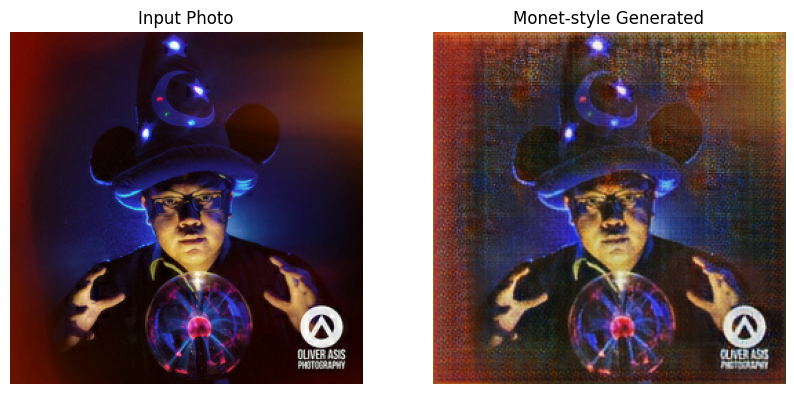

300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - monet_disc_loss: 0.6485 - monet_gen_loss: 1.9154 - photo_disc_loss: 0.6348 - photo_gen_loss: 1.9786


In [34]:
# Train the model
EPOCHS = 15

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

# Save model weights
monet_generator.save_weights(f'{TMP_DIR}/monet_generator_weights.weights.h5')

### 5.6 Training Results Visualization

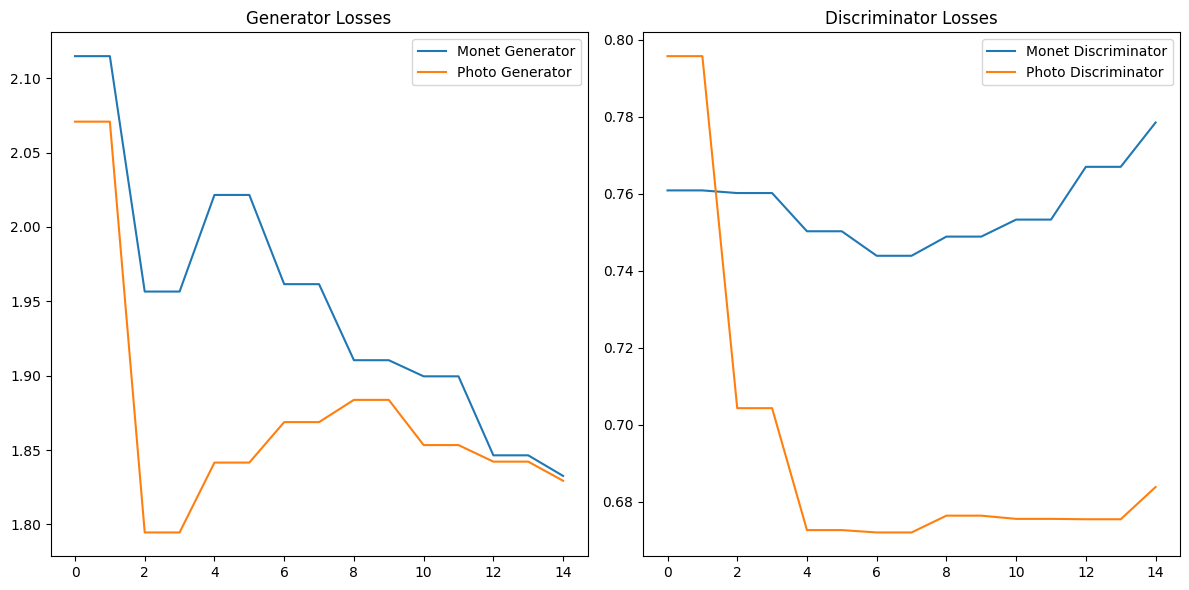

In [35]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['monet_gen_loss'], label='Monet Generator')
plt.plot(history.history['photo_gen_loss'], label='Photo Generator')
plt.title('Generator Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['monet_disc_loss'], label='Monet Discriminator')
plt.plot(history.history['photo_disc_loss'], label='Photo Discriminator')
plt.title('Discriminator Losses')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Results and Evaluation

Displaying results grid...


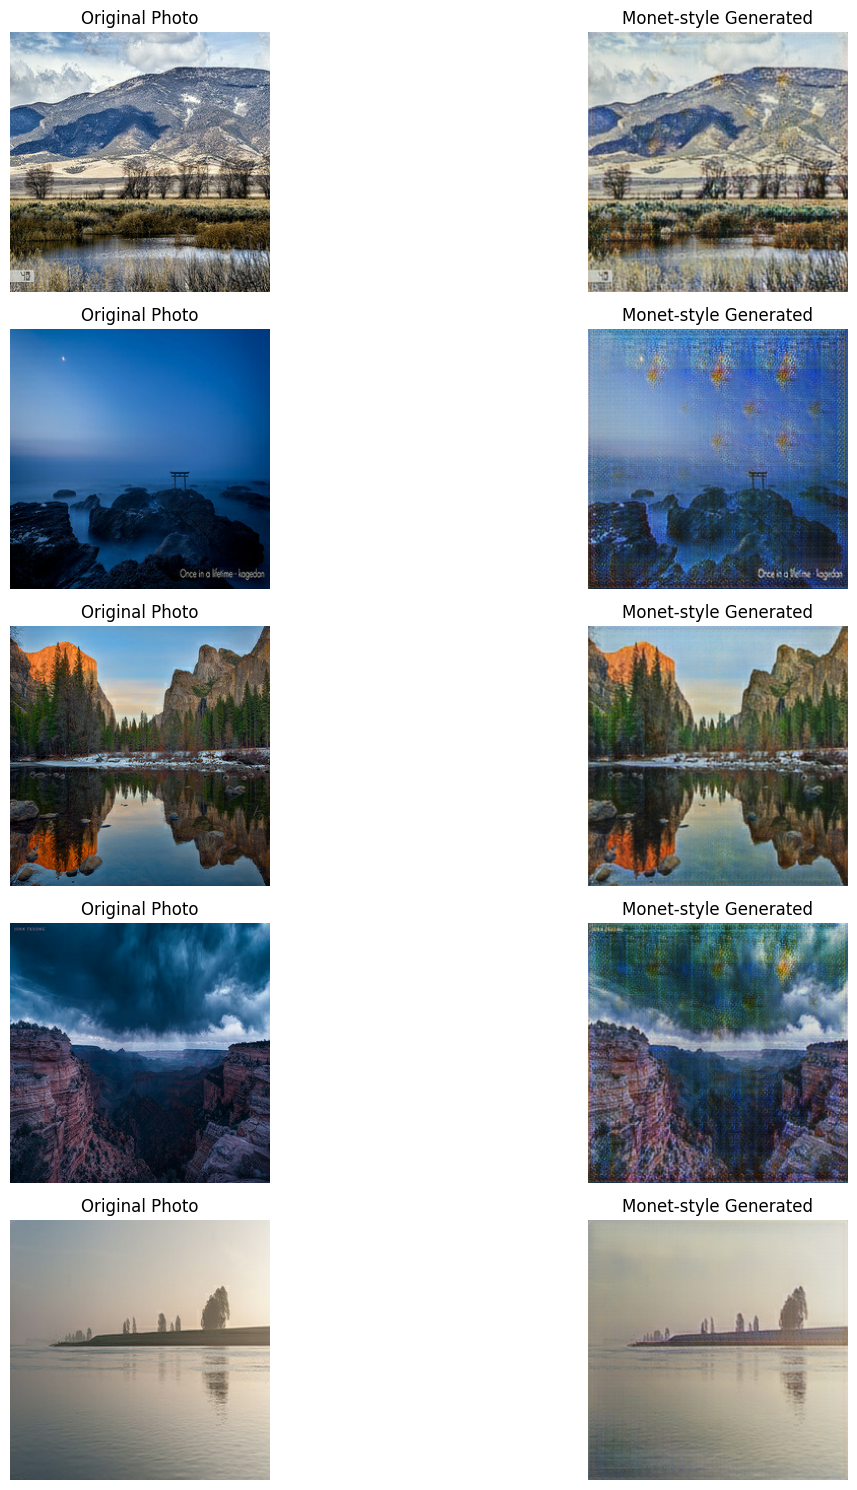

In [36]:
# Display a grid of results
def display_grid(model, ds, num_images=5, figsize=(15, 15)):
    """Display a grid of original and generated images"""
    fig, axes = plt.subplots(num_images, 2, figsize=figsize)
    
    for i, img in enumerate(ds.take(num_images)):
        prediction = model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(prediction)
        axes[i, 0].set_title("Original Photo")
        axes[i, 1].set_title("Monet-style Generated")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Display results
print("Displaying results grid...")
display_grid(monet_generator, photo_ds, num_images=5)

## 7. Generate Submission Images

In [37]:
# Create a directory for generated images
if not os.path.exists(IMAGES_TMP_DIR):
    os.makedirs(IMAGES_TMP_DIR)

In [38]:
# Create submission file directly
submission_file = "/kaggle/working/images.zip"
print("Generating images and creating submission zip file...")

# Open the zip file once and add images as we generate them
with zipfile.ZipFile(submission_file, 'w') as zip_ref:
    count = 0
    for img in photo_ds:
        if count % 100 == 0:
            print(f"Processed {count} images")
        
        # Generate the Monet-style image
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        
        # Convert to PIL image
        im = PIL.Image.fromarray(prediction)
        
        # Save directly to zip without intermediate file
        img_byte_arr = io.BytesIO()
        im.save(img_byte_arr, format='JPEG')
        img_byte_arr.seek(0)
        
        # Add to zip with appropriate name
        zip_ref.writestr(f"{count+1}.jpg", img_byte_arr.getvalue())
        
        count += 1

print(f"Total images generated and added to zip: {count}")
print(f"Submission file created: {submission_file}")

Generating images and creating submission zip file...
Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 43

In [39]:
# # Clean up any existing folders in /kaggle/working/
# path = '/kaggle/working/images.zip'
# if os.path.exists(path):
#     os.remove(path)
#     #shutil.rmtree(path)

## 8. Conclusion and Discussion
In this project, I successfully implemented a CycleGAN model to generate Monet-style paintings from photographs.

As of my last run (not this one that you're probably looking at now), I used a learning rate of 3e-4, beta1 of 0.5, and a 10 lambda_cycle. To help with convergence, I added learning rate scheduling with exponential decay. Training took about an hour (didn't time it) and 25 or fewer epochs by design. The training did not converge and I'm still scratching my head. This is something I would like to address in future work.

In future iterations, I would find it worthwhile to introduce various batch sizes and image augmentations to improve the generalization of the model. Additionally, I would make some architecture changes that I struggled to work around such as the strange dimension mismatch in my train step (if you can see what I did wrong, please comment with your critique). I would also prefer to use the TPU provided by kaggle, but I did not want to wait for my turn (ha). With more compute, better hyperparameter tuning could improve my model's performance.


All in all, the CycleGAN approach proved effective for this unpaired image-to-image translation task, allowing me to sort of capture the essence of Monet's style.

## 9 References

Thank you to Amy Jang for putting together the fantastic explanation of CycleGAN:

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial